In [3]:
!pip install pysmatch==2.0


In [4]:

import warnings
warnings.filterwarnings('ignore')
from pysmatch.Matcher import Matcher
import pandas as pd
import numpy as np

In [5]:
path = "/misc/loan.csv"
data = pd.read_csv(path)
data

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,loan_status
0,16000,16000,16000.0,36 months,18.85,585.29,D,D3,Fully Paid
1,14000,14000,14000.0,36 months,12.42,467.82,B,B4,Fully Paid
2,7200,7200,7200.0,36 months,8.99,228.93,B,B1,Fully Paid
3,19200,19200,19200.0,36 months,16.99,684.44,D,D1,Fully Paid
4,6000,6000,6000.0,36 months,12.12,199.63,B,B3,Fully Paid
...,...,...,...,...,...,...,...,...,...
21995,20000,20000,20000.0,36 months,13.58,679.48,C,C2,Default
21996,9600,9600,9600.0,36 months,25.69,385.21,F,F1,Default
21997,10000,10000,10000.0,36 months,13.49,339.31,C,C2,Default
21998,4000,4000,4000.0,36 months,18.06,144.74,D,D2,Default


In [13]:
test_data_full = data[data.loan_status == "Default"].copy() # Use .copy() to avoid SettingWithCopyWarning
control_data_full = data[data.loan_status == "Fully Paid"].copy()
treatment_var = 'is_default' 
exclude_cols = ['loan_status']

In [14]:
np.random.seed(20250604)
matcher_instance = Matcher(test=test_data_full,
                           control=control_data_full,
                           yvar=treatment_var, # Matcher will create 'is_default' column internally
                           exclude=exclude_cols)

In [15]:
# ============ (1) Noraml train (Without optuna) =============
# m.fit_scores(balance=True, nmodels=10, n_jobs=3, model_type='knn')
# m.fit_scores(balance=True, nmodels=10, n_jobs=3, model_type='tree', max_iter=100)
matcher_instance.fit_scores(balance=True, nmodels=10, model_type='tree', n_jobs=2)
# ============ (2) Utilize optuna (Only train one best model) =============
# m.fit_scores(
#     balance=True,
#     model_type='tree',
#     max_iter=200,
#     use_optuna=True,
#     n_trials=15
# )
print(f"Number of models fitted: {len(m.models)}")
print(f"Average model accuracy: {np.mean(m.model_accuracy):.4f}")

Number of models fitted: 10
Average model accuracy: 0.6647


In [18]:
matcher_instance.predict_scores()
print(matcher_instance.data[['record_id', matcher_instance.treatment_col, 'scores']].head())


   record_id  is_default    scores
0          0           1  0.561629
1          1           1  0.403468
2          2           1  0.402326
3          3           1  0.574347
4          4           1  0.578689


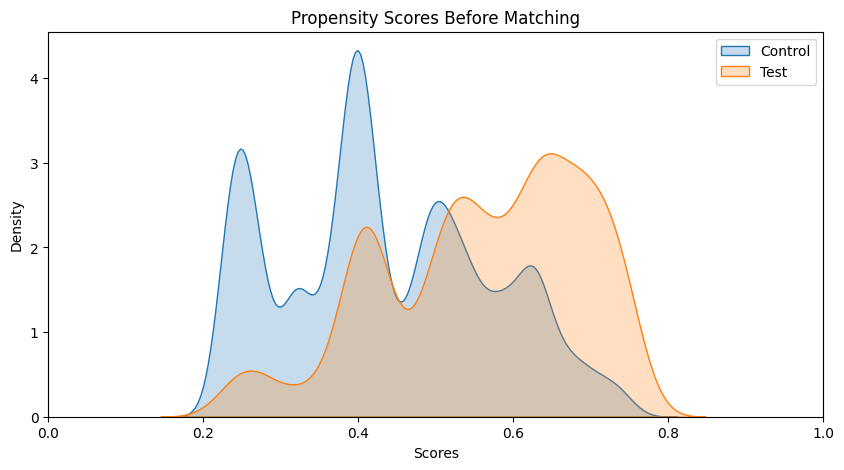

In [19]:
matcher_instance.plot_scores()

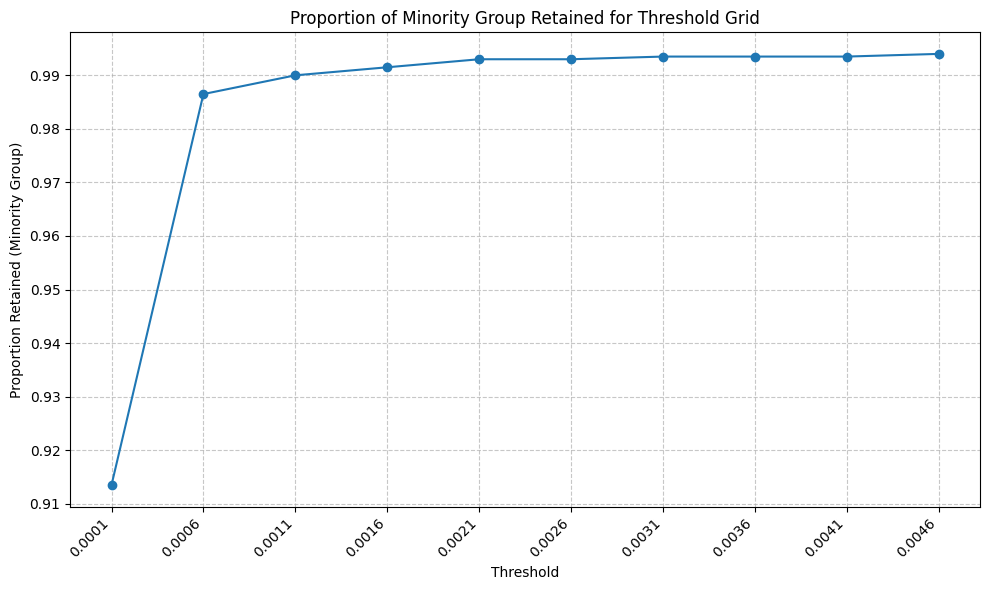

In [20]:
matcher_instance.tune_threshold(method='min', nmatches=1, rng=np.arange(0.0001, 0.0051, 0.0005))

   record_id  is_default    scores
0       1945           1  0.229664
1        277           1  0.230274
2        540           1  0.232214
3        427           1  0.232433
4        198           1  0.232462


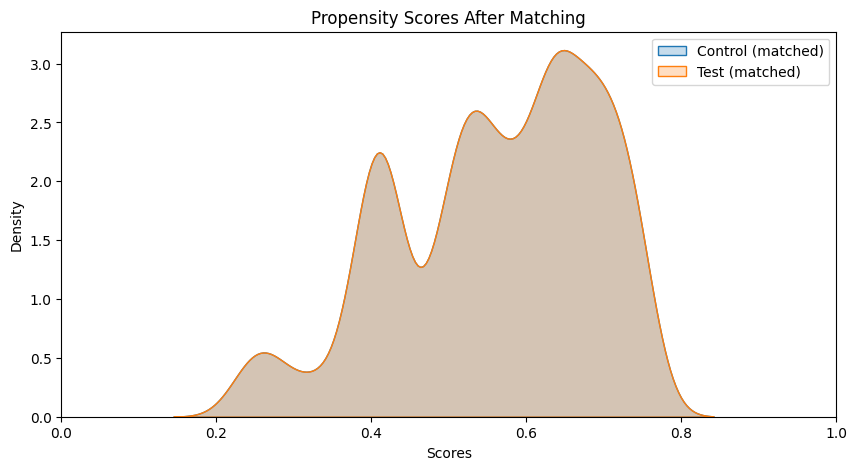

top 6 matched data
      loan_amnt  funded_amnt  funded_amnt_inv        term  int_rate  \
0          5000         5000           5000.0   36 months      5.32   
1999       5000         5000           5000.0   36 months      5.42   
1          6000         6000           6000.0   36 months      5.32   
2000       6000         6000           6000.0   36 months      5.32   
2         12000        12000          12000.0   36 months      5.32   
2001      12000        12000          12000.0   36 months      6.03   

      installment grade sub_grade loan_status  is_default  record_id  \
0          150.58     A        A1     Default           1       1945   
1999       150.80     A        A1  Fully Paid           0       6366   
1          180.69     A        A1     Default           1        277   
2000       180.69     A        A1  Fully Paid           0      21892   
2          361.38     A        A1     Default           1        540   
2001       365.23     A        A1  Fully Paid      

In [27]:
matcher_instance.match(threshold=0.001, nmatches=1, method='min', replacement=True, exhaustive_matching=False)
display_cols_standard = ['record_id', matcher_instance.treatment_col, 'scores']
print(matcher_instance.matched_data[display_cols_standard].head())
matcher_instance.plot_matched_scores()
freq_df = matcher_instance.record_frequency()
matcher_instance.assign_weight_vector()
print("top 6 matched data")
print(matcher_instance.matched_data.sort_values("match_id").head(6))

Exhaustive Matching: 100%|██████████| 2000/2000 [00:07<00:00, 257.57it/s]


   record_id  is_default    scores  match_id matched_as  pair_score_diff
0          0           1  0.561629         0       case         0.000040
1       2268           0  0.561669         0    control         0.000040
2          1           1  0.403468         1       case         0.000000
3       2288           0  0.403468         1    control         0.000000
4          2           1  0.402326         2       case         0.000019


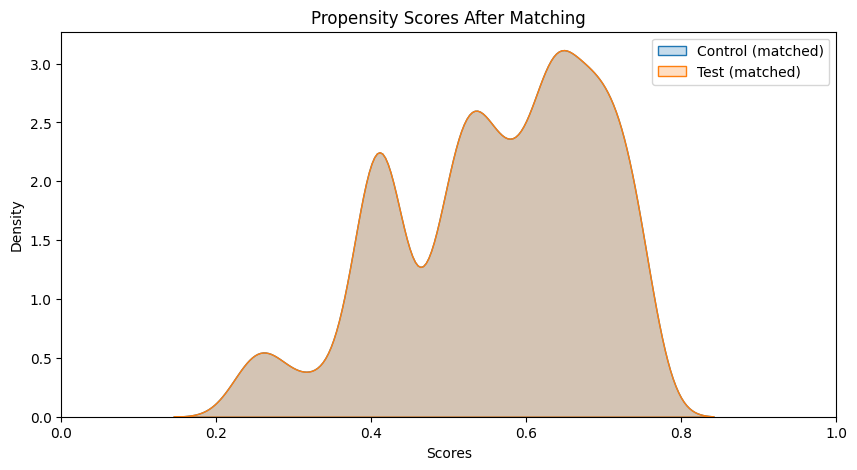

In [29]:
matcher_instance.match(threshold=0.001, nmatches=1, exhaustive_matching=True)
display_cols_exhaustive = ['record_id', matcher_instance.treatment_col, 'scores', 'match_id', 'matched_as', 'pair_score_diff']
actual_display_cols_exhaustive = [col for col in display_cols_exhaustive if col in matcher_instance.matched_data.columns]
print(matcher_instance.matched_data[actual_display_cols_exhaustive].head())
matcher_instance.plot_matched_scores()

In [30]:
control_usage_freq = matcher_instance.record_frequency()
print(control_usage_freq.head())
matcher_instance.assign_weight_vector()
weight_display_cols = ['record_id', 'match_id', 'weight']
if 'matched_as' in matcher_instance.matched_data.columns:
    weight_display_cols.append('matched_as')
actual_weight_display_cols = [col for col in weight_display_cols if col in matcher_instance.matched_data.columns]
print(matcher_instance.matched_data[actual_weight_display_cols].head())

   record_id  n_occurrences_as_control
0      17241                         5
1      20729                         4
2      12875                         2
3       5152                         2
4      18177                         2
   record_id  match_id  weight matched_as
0          0         0     1.0       case
1       2268         0     1.0    control
2          1         1     1.0       case
3       2288         1     1.0    control
4          2         2     1.0       case


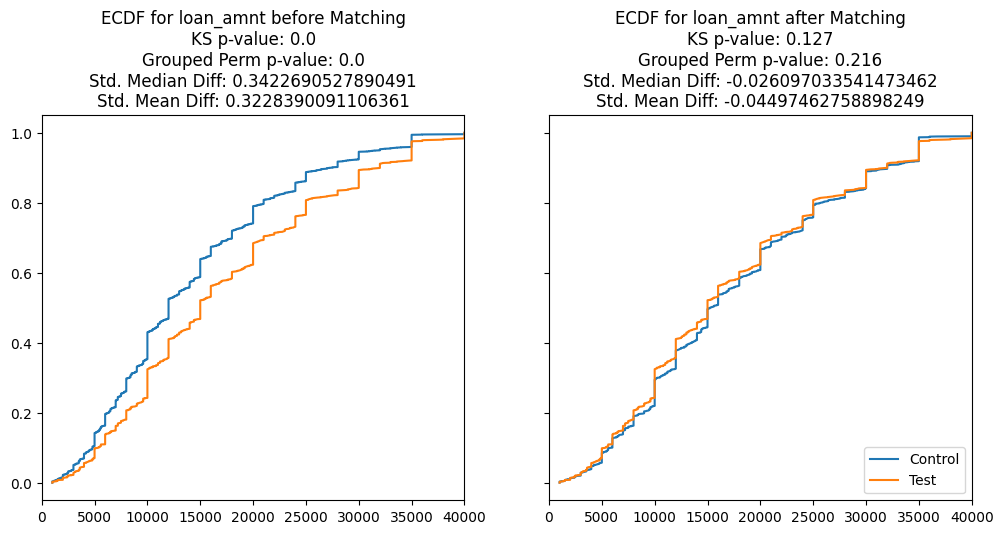

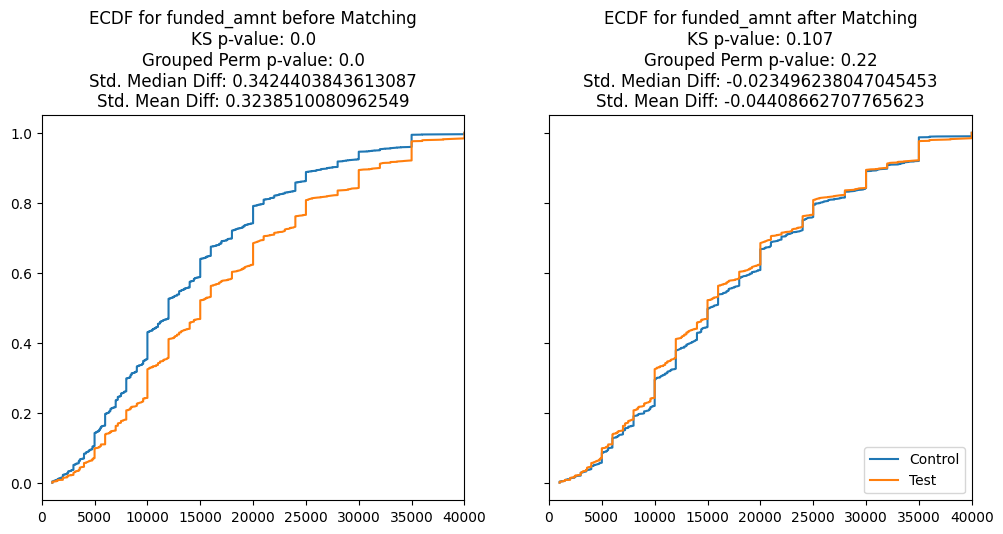

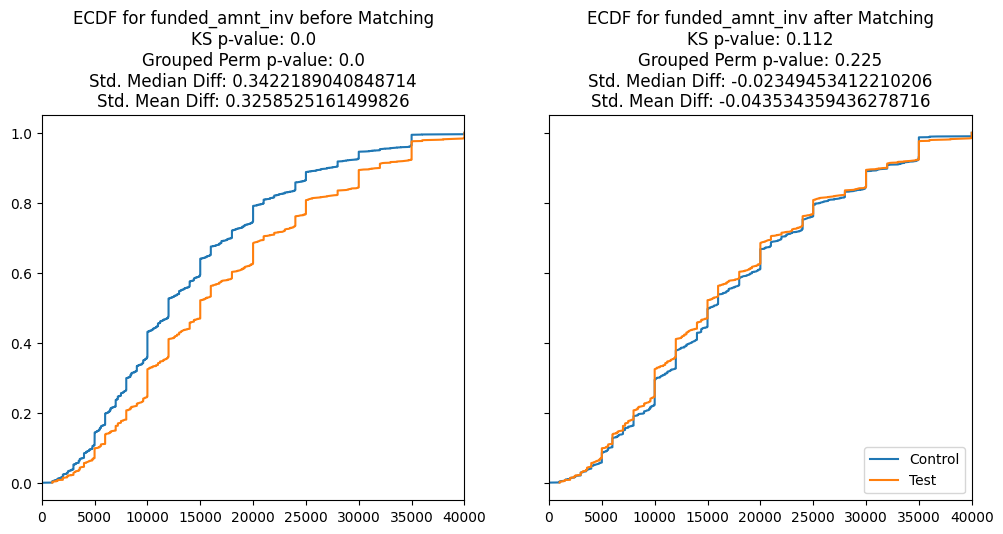

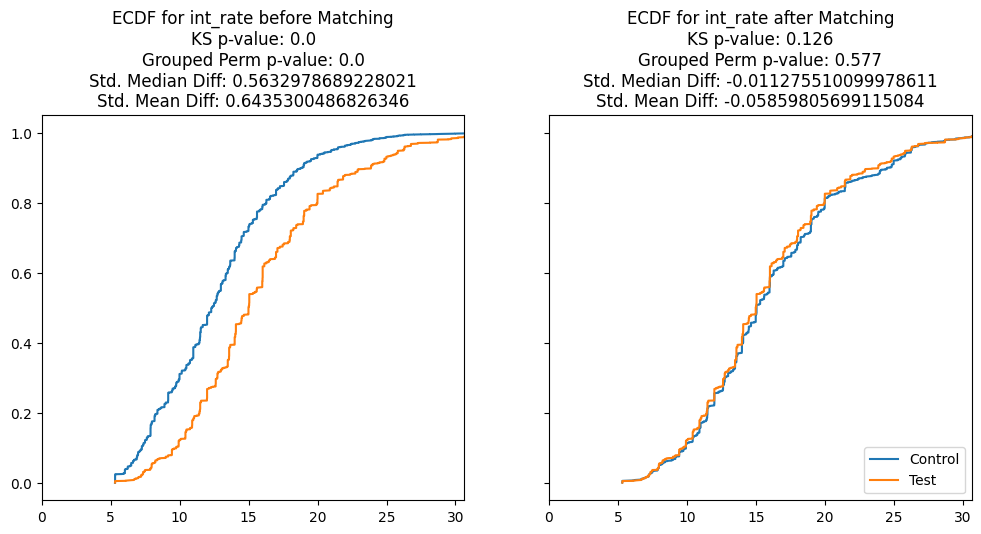

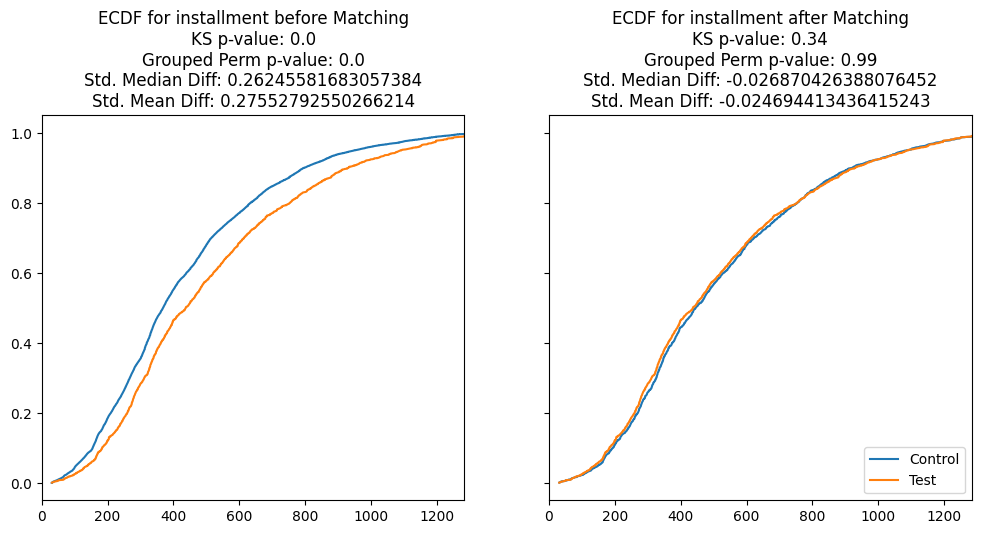

               var  ks_before  ks_after  grouped_chisqr_before  \
0        loan_amnt        0.0     0.127                    0.0   
1      funded_amnt        0.0     0.107                    0.0   
2  funded_amnt_inv        0.0     0.112                    0.0   
3         int_rate        0.0     0.126                    0.0   
4      installment        0.0     0.340                    0.0   

   grouped_chisqr_after  std_median_diff_before  std_median_diff_after  \
0                 0.216                0.342269              -0.026097   
1                 0.220                0.342440              -0.023496   
2                 0.225                0.342219              -0.023495   
3                 0.577                0.563298              -0.011276   
4                 0.990                0.262456              -0.026870   

   std_mean_diff_before  std_mean_diff_after  
0              0.322839            -0.044975  
1              0.323851            -0.044087  
2              0.

In [31]:
continuous_comparison = matcher_instance.compare_continuous(return_table=True, plot_result=True)
print(continuous_comparison)

In [35]:
grade_prop_test = matcher_instance.prop_test('grade')
print(grade_prop_test)

{'var': 'grade', 'before': 0.0, 'after': 0.00458}


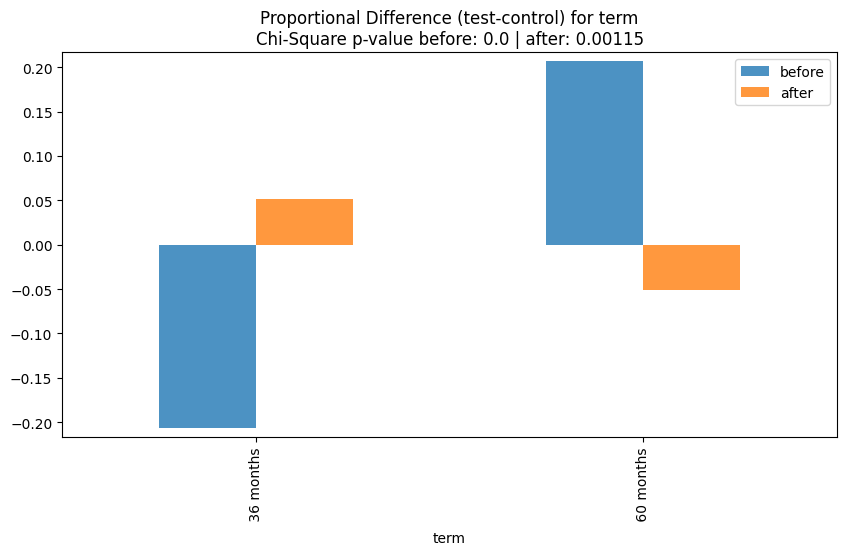

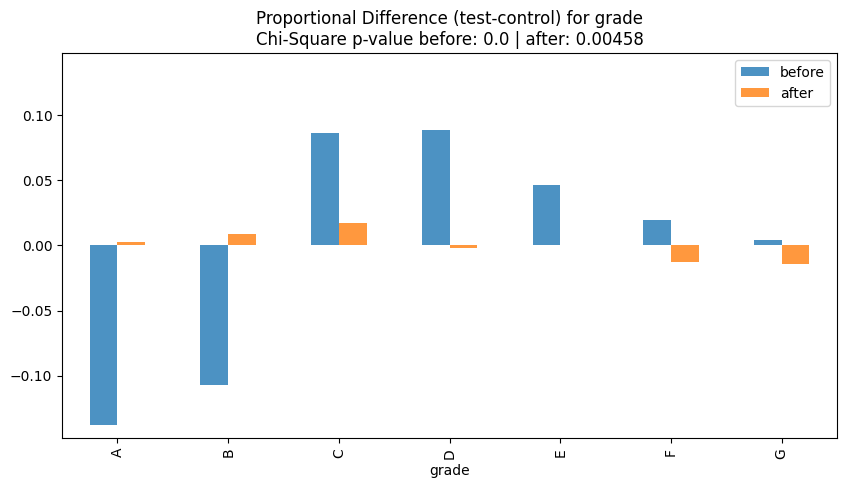

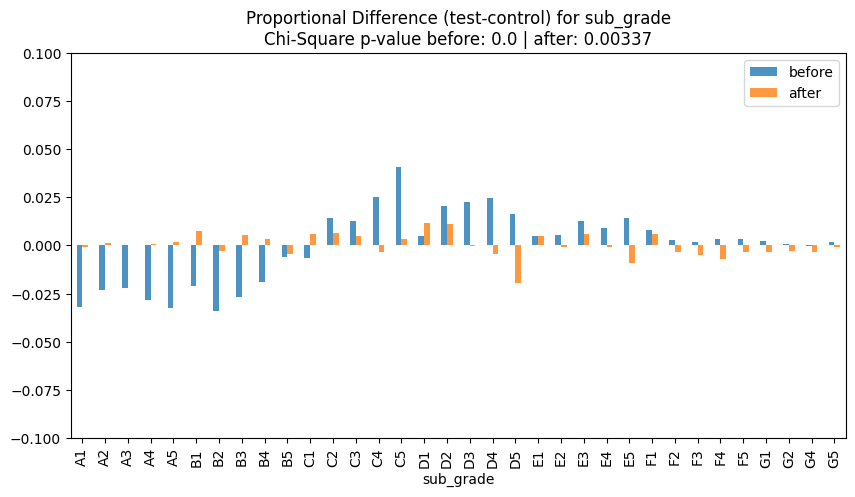

         var  before    after
0       term     0.0  0.00115
1      grade     0.0  0.00458
2  sub_grade     0.0  0.00337


In [36]:
categorical_comparison = matcher_instance.compare_categorical(return_table=True, plot_result=True)
print(categorical_comparison)